In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [4]:
true = pd.read_csv('/kaggle/input/fake-news/True.csv')
false = pd.read_csv('/kaggle/input/fake-news/Fake.csv')

<h1>EDA</h1>

In [5]:
print(true.shape)
print(false.shape)

(21417, 4)
(23481, 4)


In [6]:
print(true.isnull().sum())
print(false.isnull().sum())

title      0
text       0
subject    0
date       0
dtype: int64
title      0
text       0
subject    0
date       0
dtype: int64


In [7]:
print(true.duplicated().sum())
print(false.duplicated().sum())

206
3


In [8]:
true=true.drop_duplicates(keep='first').reset_index(drop=True)
true.shape

(21211, 4)

In [9]:
false=false.drop_duplicates(keep='first').reset_index(drop=True)
false.shape

(23478, 4)

In [10]:
import seaborn as sns
from collections import Counter
import re, string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob
import numpy as np

In [11]:
true['label'] = 1
false['label'] = 0
df = pd.concat([true, false], ignore_index=True)


Class distribution:
label
0    23478
1    21211
Name: count, dtype: int64


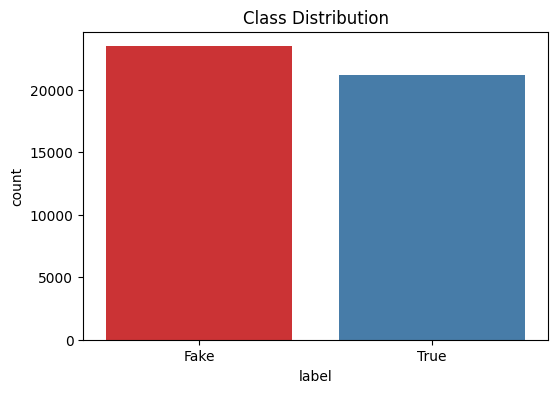

In [12]:
print("\nClass distribution:")
print(df['label'].value_counts())
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette='Set1')
plt.xticks([0,1], ['Fake','True'])
plt.title("Class Distribution")
plt.show()

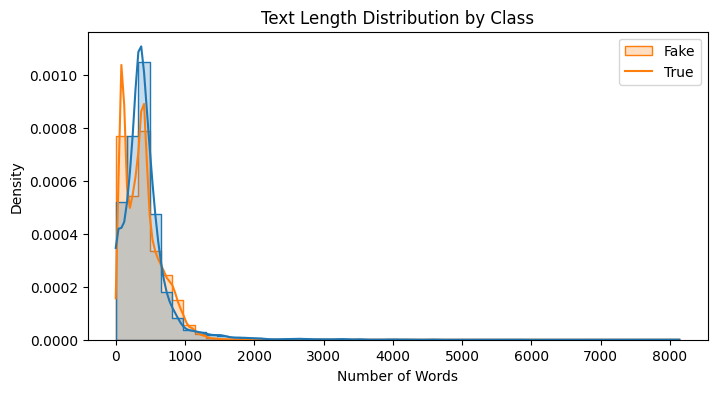

In [13]:
df['text_len'] = df['text'].astype(str).apply(lambda t: len(t.split()))
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='text_len', hue='label', bins=50, kde=True, element='step', stat='density')
plt.title("Text Length Distribution by Class")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.legend(labels=['Fake','True'])
plt.show()


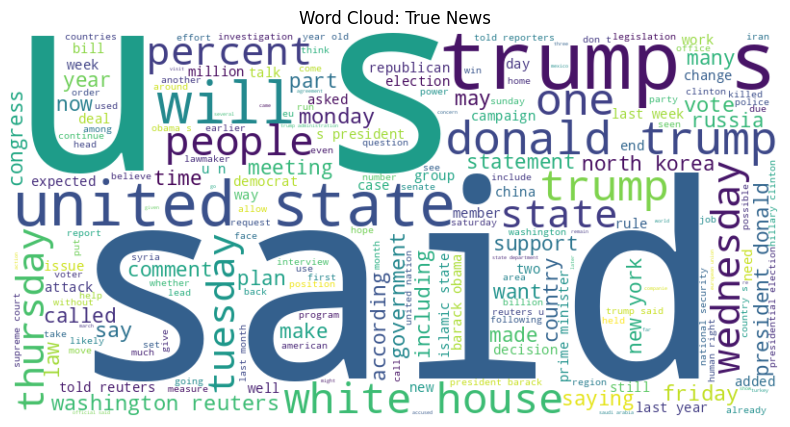

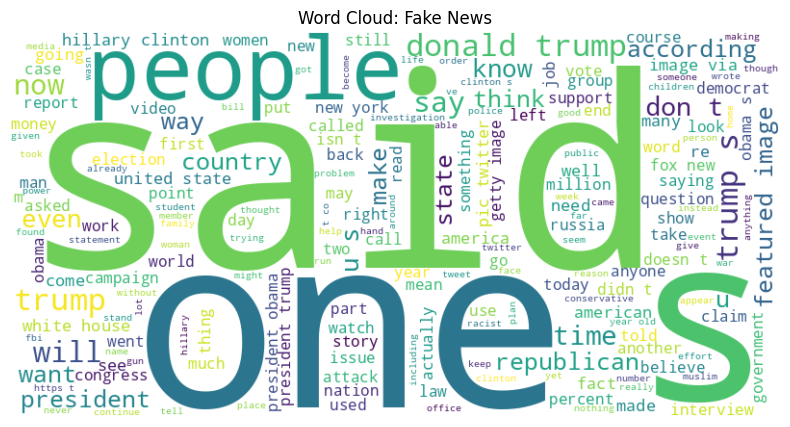

In [14]:
for lbl, title in [(1,'True News'), (0,'Fake News')]:
    text = " ".join(df[df['label']==lbl]['text'].astype(str).str.lower())
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud: {title}")
    plt.show()


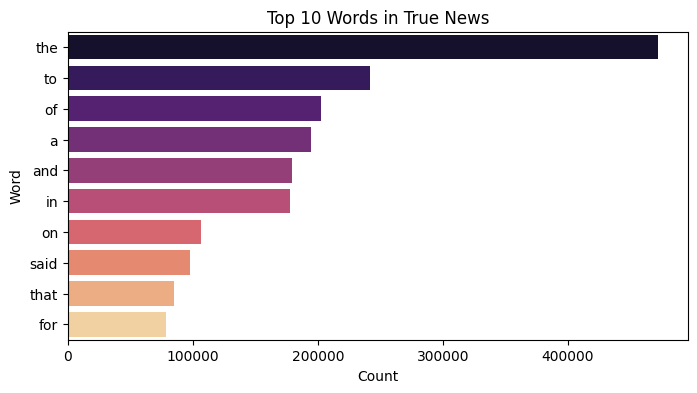

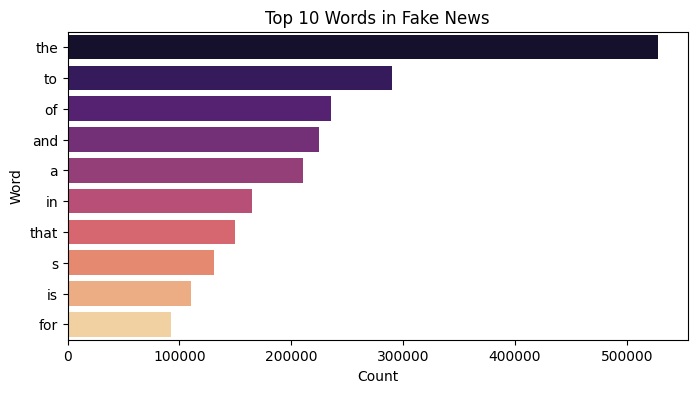

In [15]:
def preprocess(t):
    t = t.lower()
    t = re.sub(r'\d+', ' ', t)
    t = t.translate(str.maketrans('','',string.punctuation))
    return t

for lbl, title in [(1,'True News'), (0,'Fake News')]:
    words = Counter()
    for doc in df[df['label']==lbl]['text'].astype(str).apply(preprocess):
        words.update(doc.split())
    top10 = words.most_common(10)
    w, f = zip(*top10)
    plt.figure(figsize=(8,4))
    sns.barplot(x=list(f), y=list(w), palette='magma')
    plt.title(f"Top 10 Words in {title}")
    plt.xlabel("Count"); plt.ylabel("Word")
    plt.show()

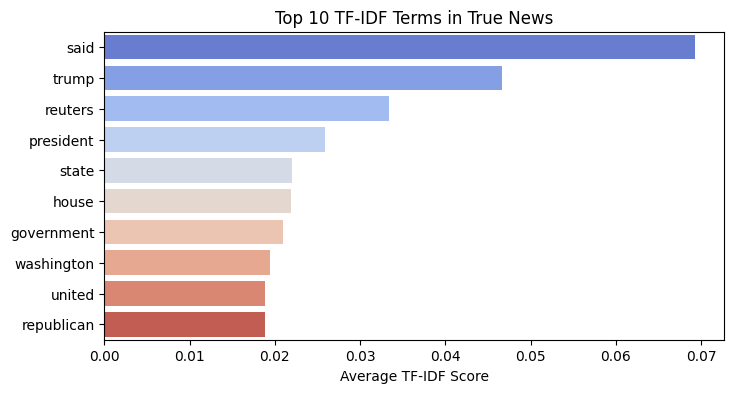

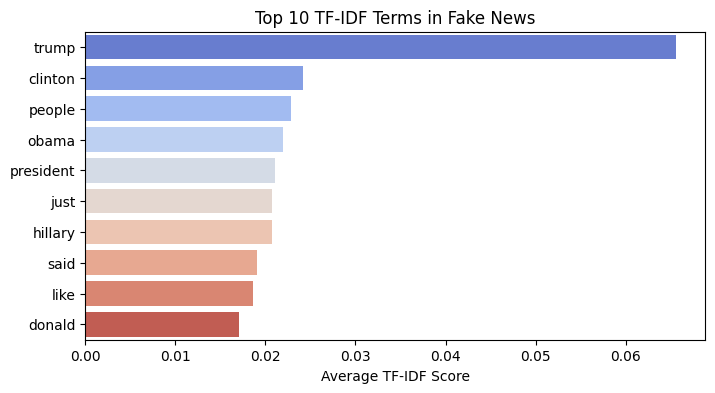

In [16]:
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')
tfidf.fit(df['text'].astype(str).apply(preprocess))
terms = tfidf.get_feature_names_out()
for lbl, title in [(1,'True News'), (0,'Fake News')]:
    X_lbl = tfidf.transform(df[df['label']==lbl]['text'].astype(str).apply(preprocess))
    ave = np.array(X_lbl.mean(axis=0)).ravel()
    top_idx = ave.argsort()[-10:][::-1]
    names = terms[top_idx]
    scores = ave[top_idx]
    plt.figure(figsize=(8,4))
    sns.barplot(x=scores, y=names, palette='coolwarm')
    plt.title(f"Top 10 TF‑IDF Terms in {title}")
    plt.xlabel("Average TF‑IDF Score")
    plt.show()

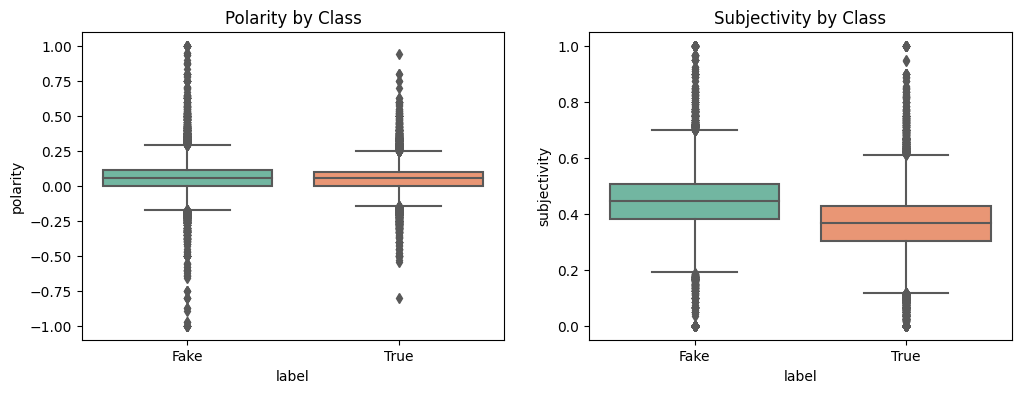

In [17]:
df['polarity'] = df['text'].astype(str).apply(lambda t: TextBlob(t).sentiment.polarity)
df['subjectivity'] = df['text'].astype(str).apply(lambda t: TextBlob(t).sentiment.subjectivity)
fig, ax = plt.subplots(1,2,figsize=(12,4))
sns.boxplot(x='label', y='polarity', data=df, ax=ax[0], palette='Set2')
ax[0].set_xticklabels(['Fake','True']); ax[0].set_title("Polarity by Class")
sns.boxplot(x='label', y='subjectivity', data=df, ax=ax[1], palette='Set2')
ax[1].set_xticklabels(['Fake','True']); ax[1].set_title("Subjectivity by Class")
plt.show()

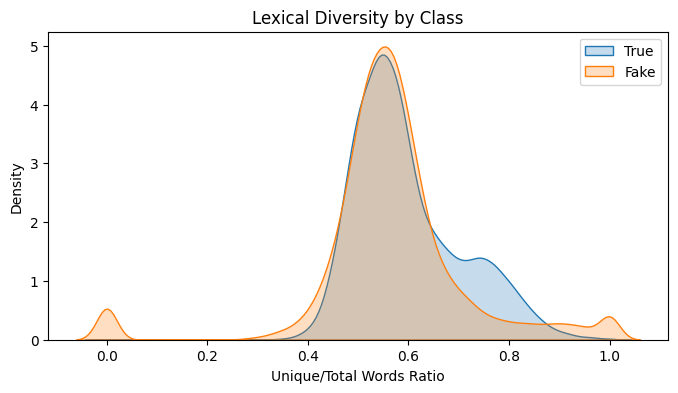

In [18]:
df['uniq_ratio'] = df['text'].astype(str).apply(
    lambda t: len(set(preprocess(t).split()))/len(preprocess(t).split()) if preprocess(t).split() else 0)
plt.figure(figsize=(8,4))
sns.kdeplot(df[df['label']==1]['uniq_ratio'], label='True', shade=True)
sns.kdeplot(df[df['label']==0]['uniq_ratio'], label='Fake', shade=True)
plt.title("Lexical Diversity by Class")
plt.xlabel("Unique/Total Words Ratio"); plt.legend()
plt.show()

In [19]:
print("\nAfter EDA, any nulls?\n", df.isnull().sum())
print("Max text length:", df['text_len'].max())
print("Min text length:", df['text_len'].min())




After EDA, any nulls?
 title           0
text            0
subject         0
date            0
label           0
text_len        0
polarity        0
subjectivity    0
uniq_ratio      0
dtype: int64
Max text length: 8135
Min text length: 0


<h1>Model Implementation</h1>

In [20]:
import pandas as pd
import numpy as np
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.optim import AdamW
import matplotlib.pyplot as plt
import seaborn as sns
import shap

2025-07-01 14:38:03.887011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751380684.390542      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751380684.512292      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [21]:
df['text'] = df['text'].astype(str).str.replace(r'[^a-zA-Z\s]', '', regex=True).str.lower()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

In [23]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, return_tensors="pt")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [24]:
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels.values)

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, y_train)
test_dataset = NewsDataset(test_encodings, y_test)

In [25]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [28]:
optimizer = AdamW(model.parameters(), lr=5e-5)

In [29]:
from tqdm import tqdm

# Training Loop with Step-wise Logging
for epoch in range(3):
    print(f"\nEpoch {epoch+1}/3")
    model.train()
    correct = 0
    total = 0
    total_loss = 0
    loop = tqdm(train_loader, leave=False)

    for step, batch in enumerate(loop, 1):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        preds = torch.argmax(logits, axis=1)
        correct += (preds == batch['labels']).sum().item()
        total += batch['labels'].size(0)
        total_loss += loss.item()

        acc = 100 * correct / total

        # Progress bar description
        loop.set_description(f"Step {step}/{len(train_loader)}")
        loop.set_postfix(loss=loss.item(), acc=f"{acc:.2f}%")

    print(f"Epoch {epoch+1} Complete — Avg Loss: {total_loss/len(train_loader):.4f} — Accuracy: {acc:.2f}%")



Epoch 1/3


Epoch 1 Complete — Avg Loss: 0.0185 — Accuracy: 99.57%

Epoch 2/3


Epoch 2 Complete — Avg Loss: 0.0085 — Accuracy: 99.81%

Epoch 3/3


Epoch 3 Complete — Avg Loss: 0.0140 — Accuracy: 99.75%


In [30]:
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
        true_labels.extend(batch['labels'].cpu().numpy())


Accuracy: 0.9970910718281495

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4648
           1       1.00      1.00      1.00      4290

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg       1.00      1.00      1.00      8938



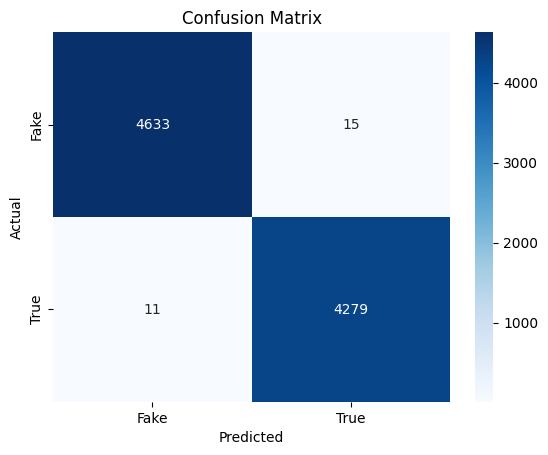

In [31]:
print("Accuracy:", accuracy_score(true_labels, predictions))
print("\nClassification Report:\n", classification_report(true_labels, predictions))
conf = confusion_matrix(true_labels, predictions)
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "True"], yticklabels=["Fake", "True"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()